In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

%matplotlib inline

In [2]:
#Connect Python to a DB
engine = create_engine("sqlite:///mta.db")

In [3]:
all_tables = engine.table_names()
all_tables

['df_covid',
 'df_mta_cleaned',
 'df_mta_cleaned1',
 'df_mta_cleaned3',
 'df_stations_mapping',
 'final_stations_list',
 'final_stations_listv2',
 'final_stations_listv3',
 'final_stations_listv4',
 'mta_data']

In [4]:
#Import the MTA data and only inculde 12am data points to calculate to daily entries;
df_mta = pd.read_sql('''
                      SELECT *
                      FROM
                        (SELECT CA
                              ,UNIT AS unit
                              ,SCP
                              ,STATION AS station
                              ,LINENAME AS linename
                              ,DIVISION AS division
                              ,date(substr(DATE,7,7) ||'-'||substr(DATE,1,2)||'-'||substr(DATE,4,2)) AS date
                              ,DESC AS desc
                              ,CAST(ENTRIES AS INT) AS entries
                              ,CAST(EXITS AS INT) AS exits
                          FROM mta_data 
                          WHERE TIME = "00:00:00")
                       WHERE date between "2020-03-01" and "2020-10-31"
                     ''', engine)

In [5]:
df_mta.head()

,CA,unit,SCP,station,linename,division,date,desc,entries,exits
0,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-01,REGULAR,326919,995477
1,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-02,REGULAR,327136,996201
2,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-03,REGULAR,328115,999054
3,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-04,REGULAR,329220,1002104
4,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,2020-03-05,REGULAR,330246,1005296


### Data Wrangling

In [6]:
df_mta.sort_values(["CA","unit","SCP","station", "date"],
                  inplace = True, ascending = False)

In [7]:
#Remove dupicated rows because those are Recovr Aud records
df_mta.drop_duplicates(subset=["CA","unit","SCP","station", "date"], inplace = True)

In [8]:
df_mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611145 entries, 27245 to 11098
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   CA        611145 non-null  object
 1   unit      611145 non-null  object
 2   SCP       611145 non-null  object
 3   station   611145 non-null  object
 4   linename  611145 non-null  object
 5   division  611145 non-null  object
 6   date      611145 non-null  object
 7   desc      611145 non-null  object
 8   entries   611145 non-null  int64 
 9   exits     611145 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 51.3+ MB


In [9]:
#Calculate the daily entries by using each day's entries to minus the previous date
df_mta[["date_next", "entries_next"]] = df_mta.groupby(["CA","unit","SCP","station"])["date","entries"].shift(1)


<ipython-input-9-e24b04766428>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mta[["date_next", "entries_next"]] = df_mta.groupby(["CA","unit","SCP","station"])["date","entries"].shift(1)


In [10]:
def get_daily_counts(df, max_counter = 1500000):
    counter = df["entries_next"] - df["entries"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        return 0
    return counter

In [11]:
df_mta["daily_entries"] = df_mta.apply(get_daily_counts, axis = 1)

In [12]:
from datetime import datetime, timedelta

In [13]:
df_mta['date'] = pd.to_datetime(df_mta['date'], format='%Y-%m-%d')

#week begins on Monday
df_mta['week_begin'] = df_mta['date'] - pd.to_timedelta(df_mta['date'].dt.dayofweek, unit='d')


In [ ]:
#Upload the cleaned mta data into mta.db for SQl practice
#df_mta.to_sql("df_mta_cleaned", engine, index = False) 

In [14]:
df_mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611145 entries, 27245 to 11098
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CA             611145 non-null  object        
 1   unit           611145 non-null  object        
 2   SCP            611145 non-null  object        
 3   station        611145 non-null  object        
 4   linename       611145 non-null  object        
 5   division       611145 non-null  object        
 6   date           611145 non-null  datetime64[ns]
 7   desc           611145 non-null  object        
 8   entries        611145 non-null  int64         
 9   exits          611145 non-null  int64         
 10  date_next      606704 non-null  object        
 11  entries_next   606704 non-null  float64       
 12  daily_entries  606704 non-null  float64       
 13  week_begin     611145 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), objec

In [16]:
#import the remote_complex_lookup.csv to map turnstiles to borough
df_stations_mapping = pd.read_csv("remote_complex_lookup.csv")
df_stations_mapping.head()

,remote,booth,complex_id,station,line_name,division,Borough
0,R001,A060,635.0,WHITEHALL ST,R1,BMT,M
1,R001,A058,635.0,WHITEHALL ST,R1,BMT,M
2,R001,R101S,635.0,SOUTH FERRY,R1,IRT,M
3,R002,A077,628.0,FULTON ST,ACJZ2345,BMT,M
4,R002,A081,628.0,FULTON ST,ACJZ2345,BMT,M


In [ ]:
#df_stations_mapping.to_sql("df_stations_mapping", engine, index = False)

In [17]:
#Create the master dataset to map each turnstile into a borough
df_mta_master = pd.read_sql('''
                      select a.*
                            ,lower(b.Borough) as borough
                      from df_mta_cleaned a LEFT join
                      (select remote,Borough
                      from df_stations_mapping
                      group by 1,2) b
                      on a.unit = b.remote
                      WHERE a.daily_entries > 0;
                      ''',engine)

In [18]:
df_mta_master[df_mta_master.borough.isna()]["station"].unique()

array(['RIT-ROOSEVELT', 'RIT-MANHATTAN', 'EXCHANGE PLACE',
       'ORCHARD BEACH', 'JFK JAMAICA CT1', 'HOWARD BCH JFK'], dtype=object)

In [19]:
df_mta_master['date'] = pd.to_datetime(df_mta_master['date'], format='%Y-%m-%d')
df_mta_master['week_begin'] = pd.to_datetime(df_mta_master['week_begin'], format='%Y-%m-%d')
df_mta_master["year_month"] = df_mta_master["date"].dt.strftime('%Y-%m')

In [20]:
df_mta_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543032 entries, 0 to 543031
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CA             543032 non-null  object        
 1   unit           543032 non-null  object        
 2   SCP            543032 non-null  object        
 3   station        543032 non-null  object        
 4   linename       543032 non-null  object        
 5   division       543032 non-null  object        
 6   date           543032 non-null  datetime64[ns]
 7   desc           543032 non-null  object        
 8   entries        543032 non-null  int64         
 9   exits          543032 non-null  int64         
 10  date_next      543032 non-null  object        
 11  entries_next   543032 non-null  float64       
 12  daily_entries  543032 non-null  float64       
 13  week_begin     543032 non-null  datetime64[ns]
 14  borough        542850 non-null  object        
 15  

In [21]:
df_mta_master.describe().astype(int)

,entries,exits,entries_next,daily_entries
count,543032,543032,543032,543032
mean,49307336,43265037,49307555,374
std,239201301,225261854,239201284,8771
min,0,0,0,1
25%,736452,416478,736442,65
50%,3081848,1805793,3082070,166
75%,7850251,5746007,7850418,366
max,2128785460,2123349140,2128784828,1483136


### Data Visualization

In [22]:
# Visualize the median of daily entries to obsevve the patterns of this metric
tmp1 = df_mta_master.groupby("date")["daily_entries"].median().reset_index()

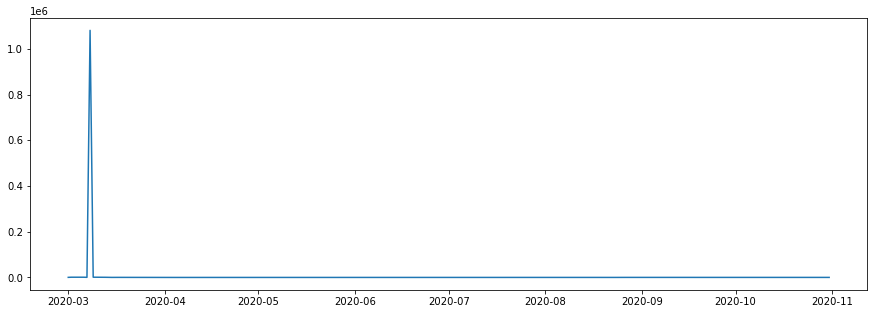

In [23]:
plt.figure(figsize = (15,5))
plt.plot(tmp1.date, tmp1.daily_entries)

#### March data is significantly higher than other months, let's take a further look.

In [24]:
tmp1.sort_values(by = "daily_entries", ascending = False)

,date,daily_entries
7,2020-03-08,1080693.0
2,2020-03-03,1079.0
8,2020-03-09,1074.5
4,2020-03-05,1054.5
9,2020-03-10,1053.0
...,...,...
41,2020-04-11,42.0
49,2020-04-19,38.0
35,2020-04-05,38.0
56,2020-04-26,36.0


In [25]:
tmp1_mar_check = tmp1[(tmp1["date"] >= "2020-03-01") & (tmp1["date"] < "2020-03-15")]


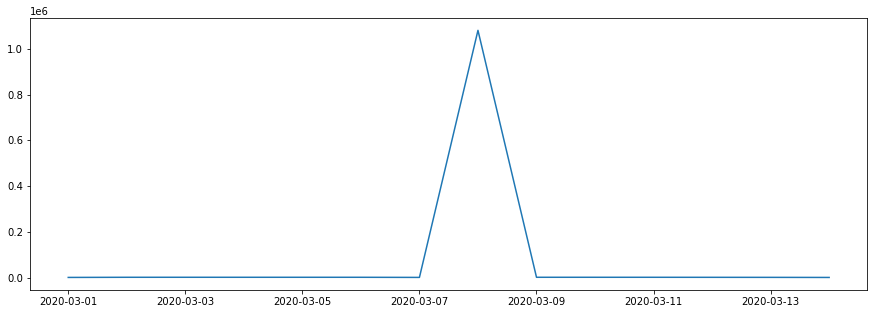

In [26]:
plt.figure(figsize = (15,5))
plt.plot(tmp1_mar_check.date, tmp1_mar_check.daily_entries)

#### The extreme value appears in 2020-03-08, let's pull it from the master data

In [27]:
df_mta_master[(df_mta_master['date'] == "2020-03-08")].sort_values("daily_entries", ascending = False)

,CA,unit,SCP,station,linename,division,date,desc,entries,exits,date_next,entries_next,daily_entries,week_begin,borough,year_month
102186,R315,R406,01-00-00,PROSPECT AV,25,IRT,2020-03-08,REGULAR,1080701,1773230,2020-10-05,8.0,1080693.0,2020-03-02,bx,2020-03


In [28]:
# Remove the data point of 2020-03-08 as it was identified as an outlier and it will skew the data a lot when we calculate the avg weekly entries
df_mta_masterV2 = df_mta_master[(df_mta_master["date"] != "2020-03-08")]

In [29]:
tmp1 = df_mta_masterV2.groupby(["date"])["daily_entries"].median().reset_index()

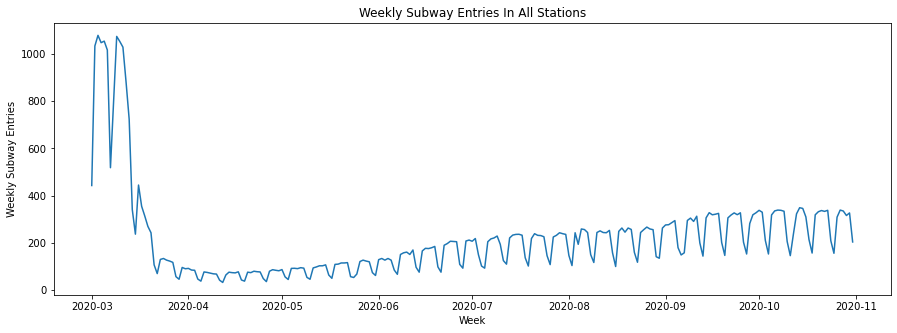

In [30]:
plt.figure(figsize = (15,5))
plt.plot(tmp1.date, tmp1.daily_entries)

plt.title("Weekly Subway Entries In All Stations")
plt.xlabel("Week")
plt.ylabel("Weekly Subway Entries");

In [31]:
#Visualize the data by borough
tmp2 = df_mta_masterV2.groupby(["borough","date"])["daily_entries"].median().reset_index()


In [32]:
# create borough_label for plots use
def new_label(row):
    if row['borough'] == 'bk':
        return "Brooklyn"
    elif row['borough'] == 'bx':
        return "Bronx"
    elif row['borough'] == 'm':
        return 'Manhattan'
    elif row['borough'] == 'q':
        return "Queens"
    elif row['borough'] == 'si':
        return "Staten Island"

In [33]:
tmp2['borough_label'] = tmp2.apply(new_label, axis = 1)

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


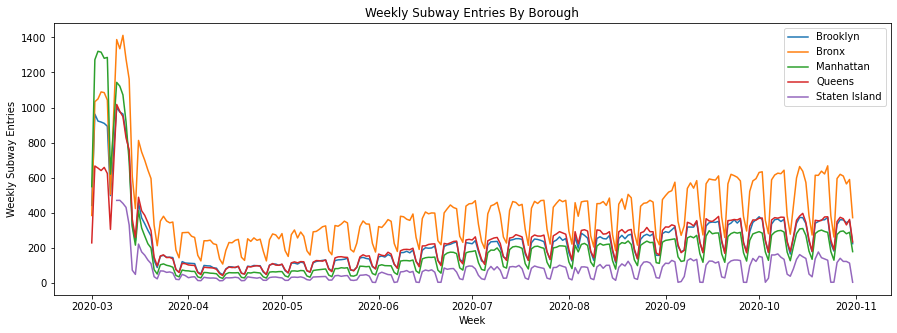

In [34]:
plt.figure(figsize = (15,5))
sns.lineplot("date","daily_entries", data = tmp2, hue = "borough_label")

plt.title("Weekly Subway Entries By Borough")
plt.xlabel("Week")
plt.ylabel("Weekly Subway Entries")
plt.legend();

In [36]:
#export the final version of MTA data into CSV

df_mta_masterV2.to_csv("df_mta_masterV2.csv", index = False)

### It looks SI(Staten Island) is missing data after 2020-11

### Data Analysis

In [37]:
# Accoridng to the Covid data documentation, the #Covid cases is not accurate, and they recomended to use the death count instead.
# In this analysis I use the Covid death count as an indicator of Covid cases.
df_covid = pd.read_sql(
                        '''SELECT 
                               date(substr(date_of_interest,7,7) ||'-'||substr(date_of_interest,1,2)||'-'||substr(date_of_interest,4,2)) AS date
                               ,SUM(BX_DEATH_COUNT) as bx
                               ,SUM(MN_DEATH_COUNT) AS m
                               ,SUM(QN_DEATH_COUNT) AS q
                               ,SUM(SI_DEATH_COUNT) AS si
                               ,SUM(BK_DEATH_COUNT) AS bk
                            FROM df_covid
                            GROUP BY 1''', engine)
df_covid.head()

,date,bx,m,q,si,bk
0,2020-02-29,0,0,0,0,0
1,2020-03-01,0,0,0,0,0
2,2020-03-02,0,0,0,0,0
3,2020-03-03,0,0,0,0,0
4,2020-03-04,0,0,0,0,0


In [38]:
#Pivot the table in order to join it with the mta master data
df_covid_t = df_covid.melt(id_vars = ["date"],
                                    var_name = "borough",
                                    value_name = "cases")
df_covid_t.head()

,date,borough,cases
0,2020-02-29,bx,0
1,2020-03-01,bx,0
2,2020-03-02,bx,0
3,2020-03-03,bx,0
4,2020-03-04,bx,0


In [39]:
df_covid_t["date"] = pd.to_datetime(df_covid_t["date"], format = "%Y-%m-%d")
df_covid_t['week_begin'] = df_covid_t["date"] - pd.to_timedelta(df_covid_t["date"]
                                                                          .dt.dayofweek, unit='d')

In [40]:
df_covid_t['borough_label'] = df_covid_t.apply(new_label, axis = 1)

In [41]:
df_covid_t.head()

,date,borough,cases,week_begin,borough_label
0,2020-02-29,bx,0,2020-02-24,Bronx
1,2020-03-01,bx,0,2020-02-24,Bronx
2,2020-03-02,bx,0,2020-03-02,Bronx
3,2020-03-03,bx,0,2020-03-02,Bronx
4,2020-03-04,bx,0,2020-03-02,Bronx


In [42]:
covid_tmp1 = df_covid_t.groupby("week_begin")["cases"].median().reset_index()

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


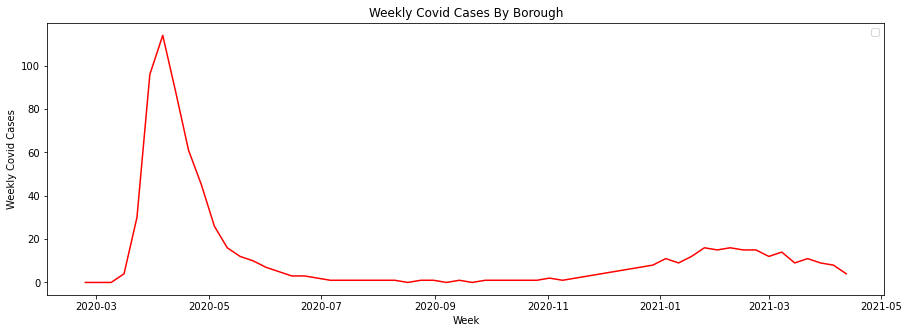

In [43]:
plt.figure(figsize = (15,5))
sns.lineplot("week_begin", "cases", data = covid_tmp1, color = 'r')

plt.title("Weekly Covid Cases By Borough")
plt.xlabel("Week")
plt.ylabel("Weekly Covid Cases")
plt.legend();

In [44]:
covid_tmp2 = df_covid_t.groupby(["borough_label","week_begin"])["cases"].median().reset_index()

/Users/wentingdeng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


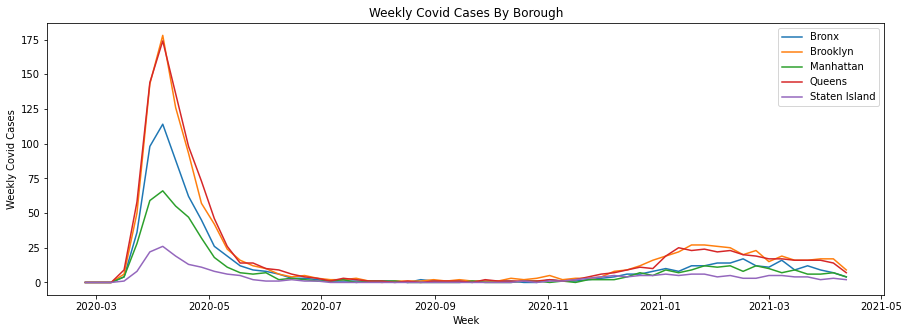

In [45]:
plt.figure(figsize = (15,5))
sns.lineplot("week_begin", "cases", hue = "borough_label", data = covid_tmp2)

plt.title("Weekly Covid Cases By Borough")
plt.xlabel("Week")
plt.ylabel("Weekly Covid Cases")

plt.legend();




In [46]:
#Create the dataset to groupby the entries and covid cases into weekly basis.
df_mta_weekly_all = df_mta_masterV2.groupby("week_begin")["daily_entries"].median().reset_index()
df_covid_weekly_all = df_covid_t.groupby("week_begin")['cases'].median().reset_index()

df_mta_weekly_all.rename(columns = {"daily_entries" : "weekly_entries"}, inplace = True)

In [47]:
#append COVID cases to df_mta_tmp1
mta_covid_weekly_all = df_mta_weekly_all.merge(df_covid_weekly_all,
                                on = ["week_begin"],
                                how = "inner")

In [48]:
mta_covid_weekly_all.head()

,week_begin,weekly_entries,cases
0,2020-02-24,443.0,0
1,2020-03-02,938.0,0
2,2020-03-09,694.0,0
3,2020-03-16,235.0,4
4,2020-03-23,101.0,30


In [49]:
mta_covid_weekly_all.to_csv("mta_covid_weekly_all.csv")

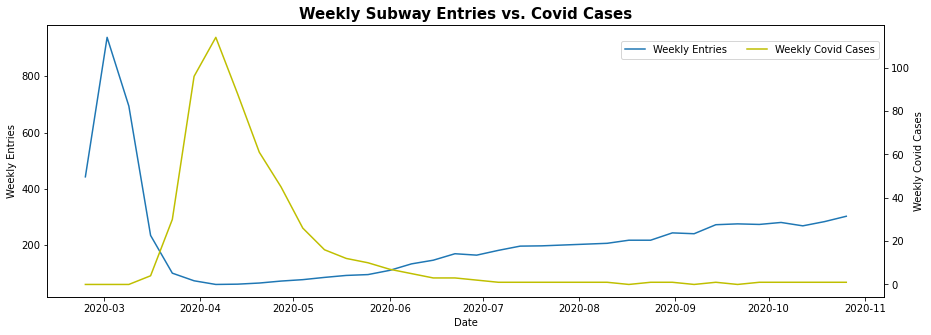

In [50]:
fig, ax = plt.subplots(figsize = (15,5))
line1, =ax.plot(mta_covid_weekly_all.week_begin,mta_covid_weekly_all.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Date")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, =ax2.plot(mta_covid_weekly_all.week_begin, mta_covid_weekly_all.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases", size = 15, fontweight='bold')

fig.legend([line1, line2], ['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor=[0.9, 0.85], 
           ncol=2)




Given the patterns observed above, I further broke down the data into two:
  * Covid Early Stage: 2020-01-01 - 2020-05-31 
  * Covid Mid-Term: 2020-06-01 - 2020-10-31
  
Notes: Holiday season was excluded from this analysis because some Staten Island is missing data after Nov 2020 as the data imcomplete issues in the station mapping file

In [51]:
mta_covid_weekly_all_early = mta_covid_weekly_all[mta_covid_weekly_all.week_begin < "2020-06-01"]

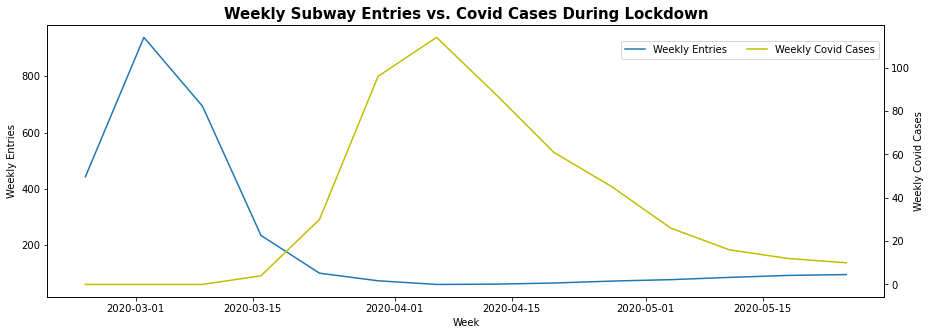

In [52]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(mta_covid_weekly_all_early.week_begin,mta_covid_weekly_all_early.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
lien2, = ax2.plot(mta_covid_weekly_all_early.week_begin, mta_covid_weekly_all_early.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases During Lockdown", size = 15, fontweight='bold')
fig.legend([line1,line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor=[0.9, 0.85],ncol=2);

In [ ]:
#fig.savefig('early_pandemic_all.png')

In [53]:
#Consider the lag of subway riderships and exposure of Covid cases I added a 4 weeks lag here
mta_covid_weekly_all_early['cases_shift'] = mta_covid_weekly_all_early.cases.shift(-4)

<ipython-input-53-d0c92d07ac8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_covid_weekly_all_early['cases_shift'] = mta_covid_weekly_all_early.cases.shift(-4)


In [54]:
mta_covid_weekly_all_early_shift = mta_covid_weekly_all_early[mta_covid_weekly_all_early["cases_shift"].notnull()]

In [55]:
np.corrcoef(mta_covid_weekly_all_early_shift.weekly_entries, mta_covid_weekly_all_early_shift.cases_shift)

array([[1.        , 0.74314761],
       [0.74314761, 1.        ]])

In [56]:
mta_covid_weekly_all_later = mta_covid_weekly_all[(mta_covid_weekly_all.week_begin >= "2020-06-01") &
                                                 (mta_covid_weekly_all.week_begin < "2020-11-01")]

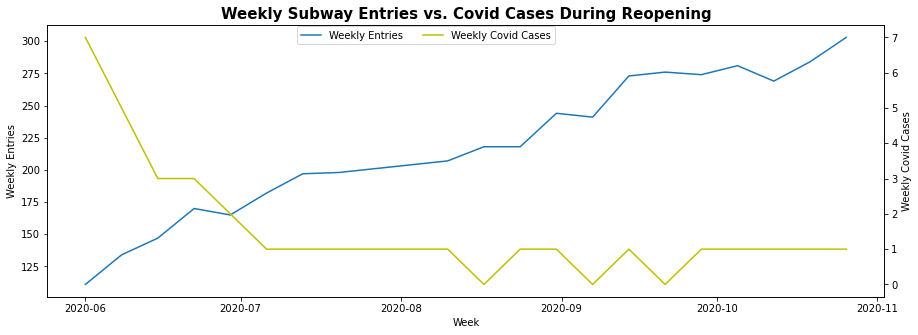

In [58]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(mta_covid_weekly_all_later.week_begin,mta_covid_weekly_all_later.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(mta_covid_weekly_all_later.week_begin, mta_covid_weekly_all_later.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Weekly Subway Entries vs. Covid Cases During Reopening", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.6, 0.89],ncol=2);



In [ ]:
#fig.savefig('midterm_pandemic_all.png')

In [59]:
# Added lag here. After testing, lag 1 returns the highest correlation.
mta_covid_weekly_all_later["cases_shift"] = mta_covid_weekly_all_later['cases'].shift(-1)
mta_covid_weekly_all_later_shift= mta_covid_weekly_all_later[mta_covid_weekly_all_later["cases_shift"].notnull()]

<ipython-input-59-d95c5e091a7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_covid_weekly_all_later["cases_shift"] = mta_covid_weekly_all_later['cases'].shift(-1)


In [60]:
np.corrcoef(mta_covid_weekly_all_later_shift.weekly_entries, mta_covid_weekly_all_later_shift.cases_shift)

array([[ 1.        , -0.70675273],
       [-0.70675273,  1.        ]])

### Analysis By Borough

In [61]:
df_mta_weekly_by_borough = df_mta_masterV2.groupby(["borough","week_begin"])["daily_entries"].median().reset_index()
df_mta_weekly_by_borough.rename(columns = {"daily_entries" : "weekly_entries"}, inplace = True)

In [62]:
df_covid_weekly_by_borough = df_covid_t.groupby(["borough","week_begin"])["cases"].median().reset_index()
df_covid_weekly_by_borough.head()

,borough,week_begin,cases
0,bk,2020-02-24,0
1,bk,2020-03-02,0
2,bk,2020-03-09,0
3,bk,2020-03-16,6
4,bk,2020-03-23,50


In [ ]:
#df_covid_weekly_by_borough.to_csv("df_covid_weekly_by_borough.csv")

In [63]:
mta_covid_weekly_by_borough = df_mta_weekly_by_borough.merge(df_covid_weekly_by_borough,
                                                            on = ["borough", "week_begin"],
                                                            how = "inner")
mta_covid_weekly_by_borough.head()

,borough,week_begin,weekly_entries,cases
0,bk,2020-02-24,441.0,0
1,bk,2020-03-02,834.5,0
2,bk,2020-03-09,651.0,0
3,bk,2020-03-16,259.5,6
4,bk,2020-03-23,118.5,50


In [64]:
bk = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'bk') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
bx = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'bx') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
m = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'm') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
q = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'q') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]
si = mta_covid_weekly_by_borough[(mta_covid_weekly_by_borough.borough == 'si') &
                                (mta_covid_weekly_by_borough.week_begin < "2020-11-01")]

In [65]:
bk_pre = bk[bk['week_begin'] < "2020-06-01"]
bx_pre = bx[bx['week_begin'] < "2020-06-01"]
m_pre = m[m['week_begin'] < "2020-06-01"]
q_pre = q[q['week_begin'] < "2020-06-01"]
si_pre = si[si['week_begin'] < "2020-06-01"]



bk_later = bk[bk['week_begin'] >= "2020-06-01"]
bx_later = bx[bx['week_begin'] >= "2020-06-01"]
m_later = m[m['week_begin'] >= "2020-06-01"]
q_later = q[q['week_begin'] >= "2020-06-01"]
si_later = si[si['week_begin'] >= "2020-06-01"]

In [ ]:
#Brooklyn

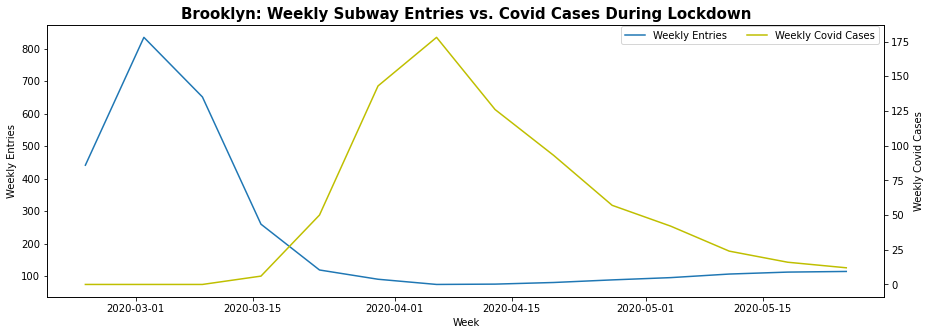

In [66]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(bk_pre.week_begin,bk_pre.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(bk_pre.week_begin, bk_pre.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Brooklyn: Weekly Subway Entries vs. Covid Cases During Lockdown", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);



In [ ]:
#fig.savefig("Brooklyn-lockdown")

In [67]:
bk_pre['cases_shift'] = bk_pre.cases.shift(-4)

<ipython-input-67-d2d7f0a53f92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_pre['cases_shift'] = bk_pre.cases.shift(-4)


In [68]:
bk_pre_shift = bk_pre[bk_pre['cases_shift'].notnull()]
bk_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
0,bk,2020-02-24,441.0,0,50.0
1,bk,2020-03-02,834.5,0,143.0
2,bk,2020-03-09,651.0,0,178.0
3,bk,2020-03-16,259.5,6,126.0
4,bk,2020-03-23,118.5,50,93.0


In [69]:
np.corrcoef(bk_pre_shift.weekly_entries, bk_pre_shift.cases_shift)

array([[1.        , 0.77601039],
       [0.77601039, 1.        ]])

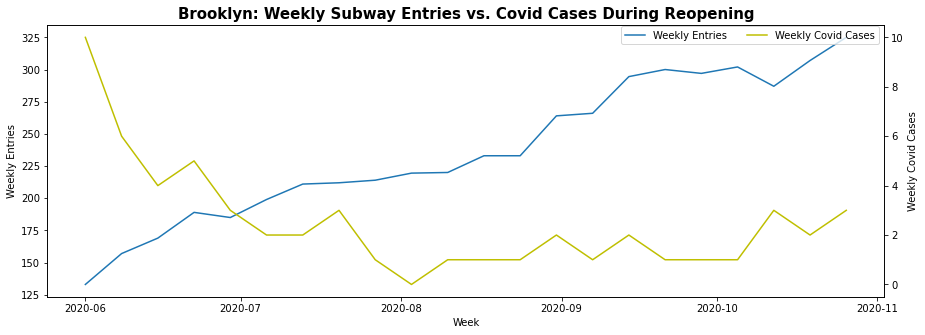

In [70]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(bk_later.week_begin,bk_later.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(bk_later.week_begin, bk_later.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Brooklyn: Weekly Subway Entries vs. Covid Cases During Reopening", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);



In [ ]:
#fig.savefig("Brooklyn-Reopening")

In [71]:
bk_later['cases_shift'] = bk_later.cases.shift(-1)
bk_later.head()

<ipython-input-71-bb535434c301>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bk_later['cases_shift'] = bk_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
14,bk,2020-06-01,133.0,10,6.0
15,bk,2020-06-08,157.0,6,4.0
16,bk,2020-06-15,169.0,4,5.0
17,bk,2020-06-22,189.0,5,3.0
18,bk,2020-06-29,185.0,3,2.0


In [72]:
bk_later_shift = bk_later[bk_later['cases_shift'].notnull()]

In [73]:
np.corrcoef(bk_later_shift.weekly_entries, bk_later_shift.cases_shift)

array([[ 1.        , -0.51652352],
       [-0.51652352,  1.        ]])

In [ ]:
#Bronx 

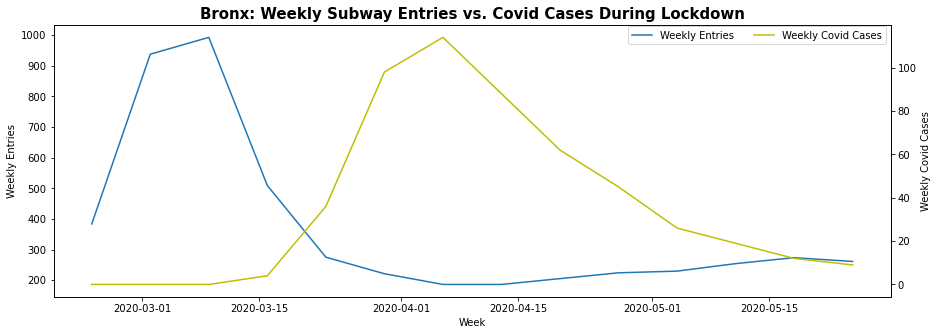

In [74]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(bx_pre.week_begin,bx_pre.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(bx_pre.week_begin, bx_pre.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Bronx: Weekly Subway Entries vs. Covid Cases During Lockdown", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);



In [ ]:
#fig.savefig("Bronx-lockdown")

In [75]:
bx_pre['cases_shift'] = bx_pre.cases.shift(-4)

<ipython-input-75-5c26ecc566df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bx_pre['cases_shift'] = bx_pre.cases.shift(-4)


In [76]:
bx_pre_shift = bx_pre[bx_pre['cases_shift'].notnull()]
bx_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
36,bx,2020-02-24,383.5,0,36.0
37,bx,2020-03-02,938.0,0,98.0
38,bx,2020-03-09,993.0,0,114.0
39,bx,2020-03-16,509.0,4,88.0
40,bx,2020-03-23,275.0,36,62.0


In [77]:
np.corrcoef(bx_pre_shift.weekly_entries, bx_pre_shift.cases_shift)

array([[1.        , 0.89210666],
       [0.89210666, 1.        ]])

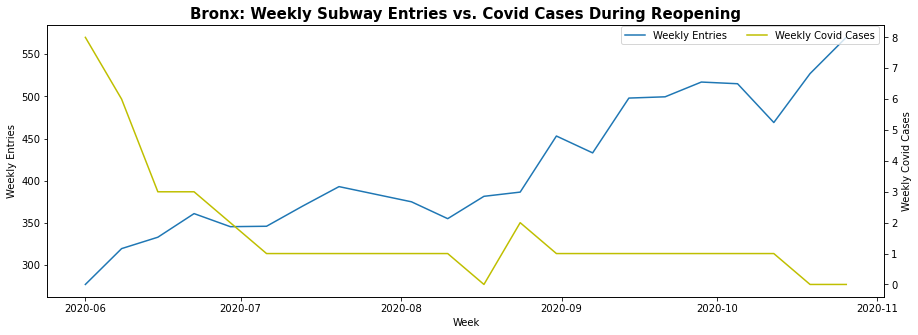

In [78]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(bx_later.week_begin,bx_later.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(bx_later.week_begin, bx_later.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Bronx: Weekly Subway Entries vs. Covid Cases During Reopening", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);



In [ ]:
#fig.savefig("Bronx-reopening")

In [79]:
bx_later['cases_shift'] = bx_later.cases.shift(-1)
bx_later.head()

<ipython-input-79-42847dcbbfac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bx_later['cases_shift'] = bx_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
50,bx,2020-06-01,277.0,8,6.0
51,bx,2020-06-08,319.5,6,3.0
52,bx,2020-06-15,333.0,3,3.0
53,bx,2020-06-22,361.0,3,2.0
54,bx,2020-06-29,345.5,2,1.0


In [80]:
bx_later_shift = bx_later[bx_later['cases_shift'].notnull()]

In [81]:
np.corrcoef(bx_later_shift.weekly_entries, bx_later_shift.cases_shift)

array([[ 1.        , -0.60234671],
       [-0.60234671,  1.        ]])

In [ ]:
#Manhattan 

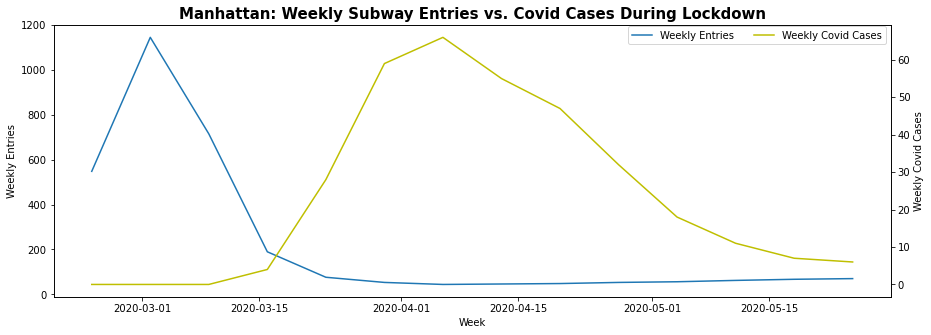

In [82]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(m_pre.week_begin,m_pre.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(m_pre.week_begin, m_pre.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Manhattan: Weekly Subway Entries vs. Covid Cases During Lockdown", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [ ]:
#fig.savefig("Manhattan-lockdown")

In [83]:
m_pre['cases_shift'] = m_pre.cases.shift(-4)

<ipython-input-83-78ac91ac1c6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_pre['cases_shift'] = m_pre.cases.shift(-4)


In [84]:
m_pre_shift = m_pre[m_pre['cases_shift'].notnull()]
m_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
72,m,2020-02-24,548.0,0,28.0
73,m,2020-03-02,1145.0,0,59.0
74,m,2020-03-09,715.0,0,66.0
75,m,2020-03-16,189.5,4,55.0
76,m,2020-03-23,76.0,28,47.0


In [85]:
np.corrcoef(m_pre_shift.weekly_entries, m_pre_shift.cases_shift)

array([[1.        , 0.66389027],
       [0.66389027, 1.        ]])

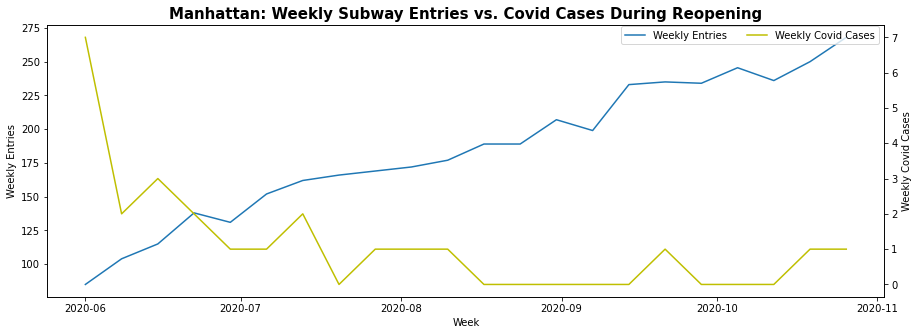

In [86]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(m_later.week_begin,m_later.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(m_later.week_begin, m_later.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Manhattan: Weekly Subway Entries vs. Covid Cases During Reopening", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [ ]:
#fig.savefig("Manhattan-reopening")

In [87]:
m_later['cases_shift'] = m_later.cases.shift(-1)
m_later.head()

<ipython-input-87-7178b86991b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_later['cases_shift'] = m_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
86,m,2020-06-01,85.0,7,2.0
87,m,2020-06-08,104.0,2,3.0
88,m,2020-06-15,115.0,3,2.0
89,m,2020-06-22,138.0,2,1.0
90,m,2020-06-29,131.0,1,1.0


In [88]:
m_later_shift = m_later[m_later['cases_shift'].notnull()]

In [89]:
np.corrcoef(m_later_shift.weekly_entries, m_later_shift.cases_shift)

array([[ 1.        , -0.65675552],
       [-0.65675552,  1.        ]])

In [ ]:
#Queens

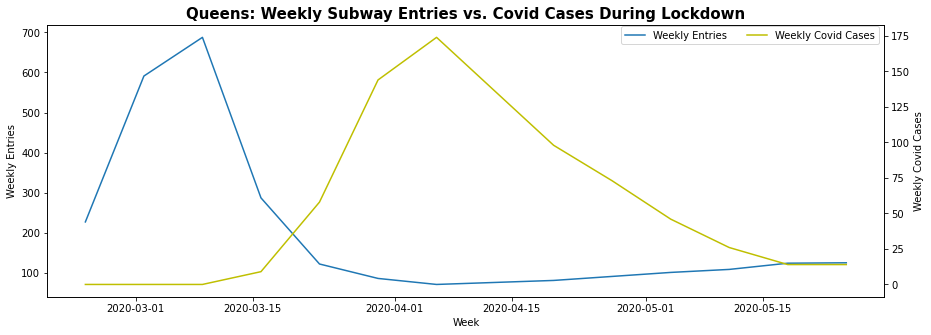

In [90]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(q_pre.week_begin,q_pre.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(q_pre.week_begin, q_pre.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Queens: Weekly Subway Entries vs. Covid Cases During Lockdown", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [ ]:
#fig.savefig("Queens-lockdown")

In [91]:
q_pre['cases_shift'] = q_pre.cases.shift(-4)

<ipython-input-91-06c7e9d6f0e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_pre['cases_shift'] = q_pre.cases.shift(-4)


In [92]:
q_pre_shift = q_pre[q_pre['cases_shift'].notnull()]
q_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
108,q,2020-02-24,227.0,0,58.0
109,q,2020-03-02,591.0,0,144.0
110,q,2020-03-09,687.5,0,174.0
111,q,2020-03-16,287.0,9,136.0
112,q,2020-03-23,122.0,58,98.0


In [93]:
np.corrcoef(q_pre_shift.weekly_entries, q_pre_shift.cases_shift)

array([[1.        , 0.86067409],
       [0.86067409, 1.        ]])

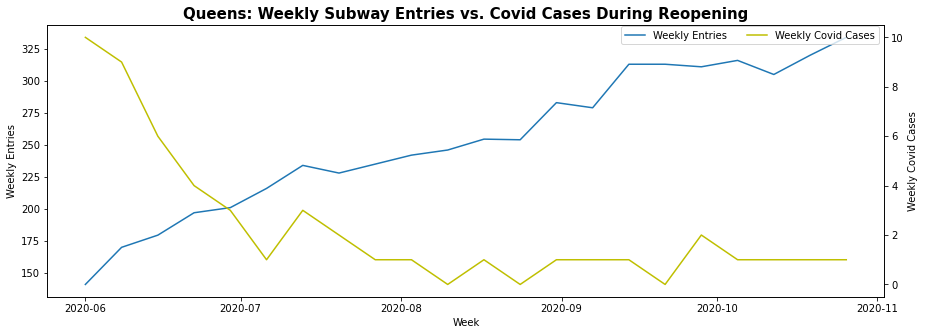

In [94]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(q_later.week_begin,q_later.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(q_later.week_begin, q_later.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Queens: Weekly Subway Entries vs. Covid Cases During Reopening", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [ ]:
#fig.savefig("Queens-reopening")

In [95]:
q_later['cases_shift'] = q_later.cases.shift(-1)
q_later.head()

<ipython-input-95-7c8c472b6ab4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_later['cases_shift'] = q_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
122,q,2020-06-01,141.0,10,9.0
123,q,2020-06-08,170.0,9,6.0
124,q,2020-06-15,179.5,6,4.0
125,q,2020-06-22,197.0,4,3.0
126,q,2020-06-29,201.0,3,1.0


In [96]:
q_later_shift = q_later[q_later['cases_shift'].notnull()]

In [97]:
np.corrcoef(q_later_shift.weekly_entries, q_later_shift.cases_shift)

array([[ 1.       , -0.7202766],
       [-0.7202766,  1.       ]])

In [ ]:
#Staten Island 

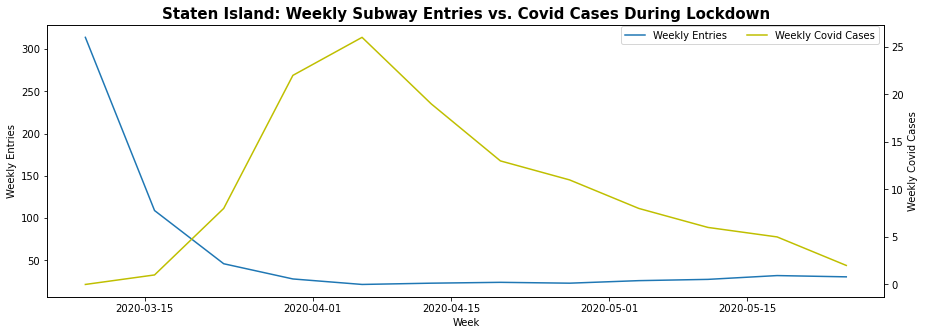

In [98]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(si_pre.week_begin,si_pre.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(si_pre.week_begin, si_pre.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Staten Island: Weekly Subway Entries vs. Covid Cases During Lockdown", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [ ]:
#fig.savefig("Staten_Island-lockdown")

In [99]:
si_pre['cases_shift'] = si_pre.cases.shift(-4)

<ipython-input-99-65a129d7cb13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_pre['cases_shift'] = si_pre.cases.shift(-4)


In [100]:
si_pre_shift = si_pre[si_pre['cases_shift'].notnull()]
si_pre_shift.head()

,borough,week_begin,weekly_entries,cases,cases_shift
144,si,2020-03-09,314.0,0,26.0
145,si,2020-03-16,109.0,1,19.0
146,si,2020-03-23,46.0,8,13.0
147,si,2020-03-30,28.0,22,11.0
148,si,2020-04-06,21.5,26,8.0


In [101]:
np.corrcoef(si_pre_shift.weekly_entries, si_pre_shift.cases_shift)

array([[1.        , 0.88306893],
       [0.88306893, 1.        ]])

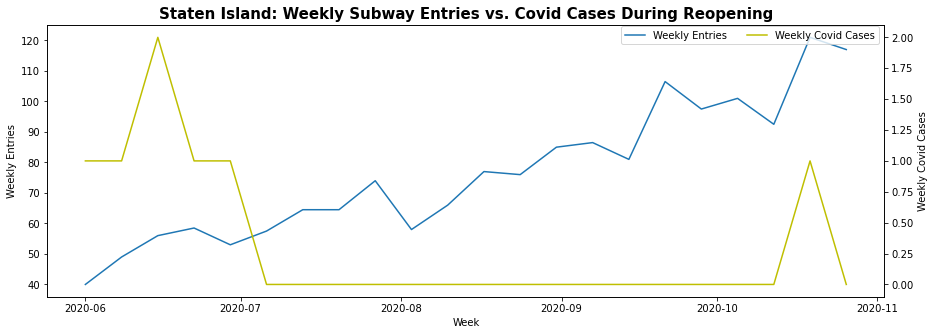

In [102]:
fig, ax = plt.subplots(figsize = (15,5))
line1, = ax.plot(si_later.week_begin,si_later.weekly_entries, label = 'weekly_entries')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Entries")


ax2 = ax.twinx()
line2, = ax2.plot(si_later.week_begin, si_later.cases, label = 'weekly_cases', c = 'y')
ax2.set_ylabel("Weekly Covid Cases")

plt.title("Staten Island: Weekly Subway Entries vs. Covid Cases During Reopening", size = 15, fontweight='bold')
fig.legend([line1, line2],['Weekly Entries', 'Weekly Covid Cases'], bbox_to_anchor = [0.9, 0.89],ncol=2);


In [ ]:
#fig.savefig("Staten_Island-reopening")

In [103]:
si_later['cases_shift'] = si_later.cases.shift(-1)
si_later.head()

<ipython-input-103-26c6c2296ced>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_later['cases_shift'] = si_later.cases.shift(-1)


,borough,week_begin,weekly_entries,cases,cases_shift
156,si,2020-06-01,40.0,1,1.0
157,si,2020-06-08,49.0,1,2.0
158,si,2020-06-15,56.0,2,1.0
159,si,2020-06-22,58.5,1,1.0
160,si,2020-06-29,53.0,1,0.0


In [104]:
si_later_shift = si_later[si_later['cases_shift'].notnull()]

In [105]:
np.corrcoef(si_later_shift.weekly_entries, si_later_shift.cases_shift)

array([[ 1.        , -0.43476323],
       [-0.43476323,  1.        ]])

In [ ]:
# find the target stations

In [ ]:
#df_mta_masterV2 = pd.read_csv("df_mta_masterV2.csv")

In [106]:
df_mta_master_midterm = df_mta_masterV2[df_mta_masterV2.date >= "2020-06-01"]
df_mta_master_midterm["date"] = pd.to_datetime(df_mta_master_midterm["date"],format = "%Y-%m-%d")
df_mta_master_midterm.head()

<ipython-input-106-8d1319c2cbe5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mta_master_midterm["date"] = pd.to_datetime(df_mta_master_midterm["date"],format = "%Y-%m-%d")


,CA,unit,SCP,station,linename,division,date,desc,entries,exits,date_next,entries_next,daily_entries,week_begin,borough,year_month
56,S101A,R070,01-05-01,ST. GEORGE,1,SRT,2020-10-18,REGULAR,756,0,2020-10-19,757.0,1.0,2020-10-12,si,2020-10
57,S101A,R070,01-05-01,ST. GEORGE,1,SRT,2020-10-17,REGULAR,755,0,2020-10-18,756.0,1.0,2020-10-12,si,2020-10
58,S101A,R070,01-05-01,ST. GEORGE,1,SRT,2020-10-02,REGULAR,754,0,2020-10-03,755.0,1.0,2020-09-28,si,2020-10
59,S101A,R070,01-05-01,ST. GEORGE,1,SRT,2020-07-01,REGULAR,753,0,2020-07-02,754.0,1.0,2020-06-29,si,2020-07
60,S101A,R070,01-05-01,ST. GEORGE,1,SRT,2020-06-09,REGULAR,752,0,2020-06-10,753.0,1.0,2020-06-08,si,2020-06


In [107]:
#Calculate the entries percentage change for each borough
borough_entries = df_mta_master_midterm.groupby(["borough","date"])["daily_entries"].median().reset_index()

borough_entries_chg = borough_entries.groupby("borough")["daily_entries"].agg([min, max])
borough_entries_chg["entries_pct_chag"] = round(100*(borough_entries_chg["max"] - borough_entries_chg["min"])/borough_entries_chg["min"],2)
borough_entries_chg = borough_entries_chg.reset_index()
borough_entries_chg = borough_entries_chg[["borough", "entries_pct_chag"]]
borough_entries_chg.head()

,borough,entries_pct_chag
0,bk,347.62
1,bx,274.72
2,m,571.74
3,q,382.32
4,si,17400.00


In [110]:
#Calculate the entries percentage change for each station
station_entries = df_mta_master_midterm.groupby(["borough","station","date"])["daily_entries"].median().reset_index()
station_entries_chg = station_entries.groupby(["borough","station"])["daily_entries"].agg([min, max])
station_entries_chg["station_entries_pct_chag"] = round(100*(station_entries_chg["max"] - station_entries_chg["min"])/station_entries_chg["min"],2)
station_entries_chg = station_entries_chg.reset_index()
station_entries_chg.head()

,borough,station,min,max,station_entries_pct_chag
0,bk,18 AV,3.5,725.0,20614.29
1,bk,20 AV,145.0,714.0,392.41
2,bk,25 ST,1.0,292.5,29150.00
3,bk,4 AV-9 ST,78.0,882.0,1030.77
4,bk,45 ST,188.5,733.0,288.86


In [111]:
station_entriesv2 = station_entries_chg.merge(borough_entries_chg,
                                         on = "borough",
                                         how = "inner")

In [112]:
station_entriesv2.rename(columns = {"min": "jun20",
                                   "max":"oct20"}, inplace = True)
station_entriesv2.head()

,borough,station,jun20,oct20,station_entries_pct_chag,entries_pct_chag
0,bk,18 AV,3.5,725.0,20614.29,347.62
1,bk,20 AV,145.0,714.0,392.41,347.62
2,bk,25 ST,1.0,292.5,29150.00,347.62
3,bk,4 AV-9 ST,78.0,882.0,1030.77,347.62
4,bk,45 ST,188.5,733.0,288.86,347.62


In [113]:
final_stations_list = station_entriesv2[station_entriesv2["station_entries_pct_chag"] >= station_entriesv2["entries_pct_chag"]]


In [115]:
final_stations_list['borough_label'] = final_stations_list.apply(new_label, axis = 1)
final_stations_list = final_stations_list[["borough_label", "station", "station_entries_pct_chag"]]


<ipython-input-115-84989a5b01a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stations_list['borough_label'] = final_stations_list.apply(new_label, axis = 1)


In [116]:
final_stations_list.sort_values(by = ["borough_label", "station_entries_pct_chag"], ascending = False, inplace = True)
final_stations_list.head()

,borough_label,station,station_entries_pct_chag
215,Staten Island,ST. GEORGE,17400.00
196,Queens,COURT SQ-23 ST,58400.00
185,Queens,AQUEDUCT RACETR,21800.00
191,Queens,BEACH 60 ST,20380.00
209,Queens,PARSONS BLVD,4345.18


In [ ]:
#import into SQLITE for window function practice!
#final_stations_list.to_sql("final_stations_listv4", engine, index = False) 

In [117]:
top_stations_by_borough = pd.read_sql('''
                          SELECT borough_label
                                ,station
                                ,station_entries_pct_chag
                          FROM
                              (SELECT *
                                     ,ROW_NUMBER() OVER (PARTITION BY borough_label ORDER BY station_entries_pct_chag DESC) AS rk
                               FROM final_stations_listv4)
                          WHERE rk <= 5''',engine)



In [118]:
top_stations_by_borough['station_entries_pct_chag'] = top_stations_by_borough['station_entries_pct_chag'].astype(int)

In [119]:
top_stations_by_borough.to_csv("top_stations_by_borough.csv")

In [121]:
top_stations_by_borough.head(15)

,borough_label,station,station_entries_pct_chag
0,Bronx,138/GRAND CONC,54000
1,Bronx,PELHAM BAY PARK,16200
2,Bronx,MT EDEN AV,10007
3,Bronx,231 ST,5133
4,Bronx,182-183 STS,2951
5,Brooklyn,STERLING ST,85500
6,Brooklyn,4AV-9 ST,78200
7,Brooklyn,AVENUE P,72100
8,Brooklyn,BEVERLY RD,49950
9,Brooklyn,PRESIDENT ST,42800
